In [63]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import torch

import copy
import random
import pickle

In [53]:
def create_dataset(df, shuffle=True):

  sequences = df.astype(np.float32).to_numpy().tolist()

  dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]

  if shuffle: 
    random.Random(6).shuffle(dataset)

  n_seq, seq_len, n_features = torch.stack(dataset).shape

  return dataset, seq_len, n_features

In [54]:
df = pd.read_csv("data/mit_bih.csv", index_col=0)
df.head()

,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,t_9,...,t_170,t_171,t_172,t_173,t_174,t_175,t_176,t_177,t_178,t_179
0,0.580723,0.579518,0.581928,0.580723,0.584337,0.581928,0.581928,0.580723,0.580723,0.584337,...,0.553012,0.555422,0.554217,0.551807,0.553012,0.549398,0.550602,0.550602,0.553012,0.550602
1,0.574699,0.571084,0.571084,0.568675,0.569880,0.572289,0.574699,0.572289,0.572289,0.572289,...,0.557831,0.554217,0.556627,0.556627,0.555422,0.554217,0.553012,0.553012,0.551807,0.554217
2,0.563855,0.561446,0.568675,0.567470,0.568675,0.567470,0.567470,0.565060,0.567470,0.571084,...,0.566265,0.565060,0.563855,0.561446,0.560241,0.560241,0.563855,0.566265,0.561446,0.562651
3,0.571084,0.571084,0.569880,0.568675,0.571084,0.574699,0.574699,0.573494,0.573494,0.572289,...,0.556627,0.551807,0.551807,0.551807,0.553012,0.551807,0.545783,0.546988,0.545783,0.549398
4,0.572289,0.572289,0.572289,0.575904,0.575904,0.575904,0.571084,0.569880,0.572289,0.574699,...,0.557831,0.559036,0.559036,0.556627,0.555422,0.551807,0.551807,0.555422,0.555422,0.553012


In [55]:
df.iloc[0]

t_0      0.580723
t_1      0.579518
t_2      0.581928
t_3      0.580723
t_4      0.584337
           ...   
t_175    0.549398
t_176    0.550602
t_177    0.550602
t_178    0.553012
t_179    0.550602
Name: 0, Length: 180, dtype: float64

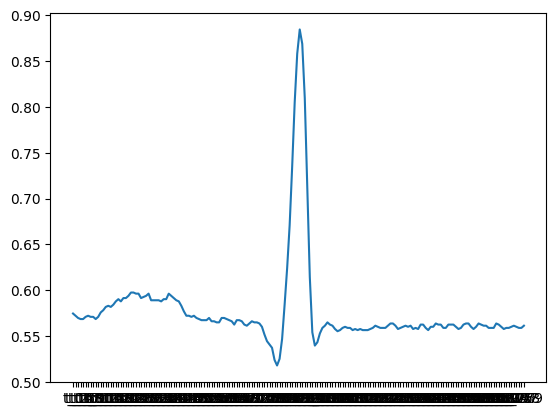

In [56]:
plt.plot(df.iloc[234,:])

In [57]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [58]:
def train_model(model, train_dataset, val_dataset, n_epochs, lr):
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  criterion = torch.nn.L1Loss(reduction='sum').to(device)
  history = dict(train=[], val=[])

  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0
  
  for epoch in range(1, n_epochs + 1):
    model = model.train()

    train_losses = []
    for seq_true in train_dataset:
      optimizer.zero_grad()

      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      loss.backward()
      optimizer.step()

      train_losses.append(loss.item())

    val_losses = []
    model = model.eval()
    with torch.no_grad():
      for seq_true in val_dataset:

        seq_true = seq_true.to(device)
        seq_pred = model(seq_true)

        loss = criterion(seq_pred, seq_true)
        val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

  model.load_state_dict(best_model_wts)
  return model.eval(), history

In [59]:
dataset,seq_len, n_feat = create_dataset(df)

In [60]:
dataset[0]

tensor([[0.5723],
        [0.5735],
        [0.5711],
        [0.5699],
        [0.5699],
        [0.5699],
        [0.5723],
        [0.5723],
        [0.5687],
        [0.5663],
        [0.5663],
        [0.5723],
        [0.5747],
        [0.5759],
        [0.5783],
        [0.5759],
        [0.5795],
        [0.5819],
        [0.5867],
        [0.5880],
        [0.5819],
        [0.5831],
        [0.5831],
        [0.5904],
        [0.5952],
        [0.5964],
        [0.5964],
        [0.5964],
        [0.5976],
        [0.5988],
        [0.6000],
        [0.6024],
        [0.5988],
        [0.5940],
        [0.5952],
        [0.5964],
        [0.6000],
        [0.6000],
        [0.6000],
        [0.5988],
        [0.6024],
        [0.6060],
        [0.6072],
        [0.5988],
        [0.5880],
        [0.5843],
        [0.5807],
        [0.5795],
        [0.5783],
        [0.5759],
        [0.5723],
        [0.5723],
        [0.5687],
        [0.5699],
        [0.5711],
        [0

In [10]:
dataset = dataset[0:5000]

In [61]:
from lstmae import RecurrentAutoencoder

model = RecurrentAutoencoder(seq_len, n_feat, device, 128)
model = model.to(device)
model

RecurrentAutoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(1, 256, batch_first=True)
    (rnn2): LSTM(256, 128, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(128, 128, batch_first=True)
    (rnn2): LSTM(128, 256, batch_first=True)
    (output_layer): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [12]:
train_ratio = 0.7
test_ratio = 0.1
train_index = int(len(dataset)*train_ratio)
test_index = int(len(dataset)*test_ratio) + train_index
train = dataset[0:train_index]
test = dataset[train_index:test_index]
val = dataset[test_index::]
assert len(train)+len(test)+len(val) == len(dataset)

In [13]:
model, history = train_model(
  model, 
  train_dataset=train, 
  val_dataset=val, 
  n_epochs=20,
  lr=1e-2
)

Epoch 1: train loss 8.095197120870862 val loss 4.570648019075394
Epoch 2: train loss 6.140729051726205 val loss 4.474429612636566
Epoch 3: train loss 6.066187230723245 val loss 4.630044482707977
Epoch 4: train loss 5.967013066768646 val loss 4.911952033996582
Epoch 5: train loss 6.065726082052503 val loss 4.827156135320664
Epoch 6: train loss 6.03094591992242 val loss 4.669893185377121
Epoch 7: train loss 5.961962776933397 val loss 5.020297659397126
Epoch 8: train loss 5.791603078978402 val loss 4.4978244407176975
Epoch 9: train loss 5.719635787010193 val loss 5.100158972978592
Epoch 10: train loss 5.822277328218733 val loss 5.972427594184875
Epoch 11: train loss 5.711576251643044 val loss 4.717722195148468
Epoch 12: train loss 5.726840373107366 val loss 6.753239604234696
Epoch 13: train loss 5.66542803818839 val loss 4.554942609786988
Epoch 14: train loss 5.737139183998108 val loss 6.12031285238266
Epoch 15: train loss 5.741015915461949 val loss 4.599425235748291
Epoch 16: train loss 

In [15]:
torch.save(model, "models/lstmae_5000")

In [69]:
torch.load("models/lstmae_5000", map_location=torch.device('cpu'))

RecurrentAutoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(1, 256, batch_first=True)
    (rnn2): LSTM(256, 128, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(128, 128, batch_first=True)
    (rnn2): LSTM(128, 256, batch_first=True)
    (output_layer): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [85]:
model = model.to(device="cpu")

In [71]:
model.state_dict()

OrderedDict([('encoder.rnn1.weight_ih_l0',
              tensor([[-0.0596],
                      [-0.0464],
                      [-0.0451],
                      ...,
                      [-0.0493],
                      [-0.0613],
                      [-0.0106]])),
             ('encoder.rnn1.weight_hh_l0',
              tensor([[-0.0580,  0.0615,  0.0593,  ...,  0.0133,  0.0152, -0.0510],
                      [-0.0082,  0.0417,  0.0395,  ..., -0.0391, -0.0515, -0.0580],
                      [ 0.0444,  0.0523, -0.0571,  ..., -0.0582,  0.0605, -0.0096],
                      ...,
                      [ 0.0587,  0.0444,  0.0195,  ..., -0.0028,  0.0233, -0.0442],
                      [ 0.0558,  0.0274,  0.0255,  ...,  0.0027,  0.0351,  0.0621],
                      [-0.0406,  0.0235, -0.0192,  ...,  0.0551, -0.0150, -0.0609]])),
             ('encoder.rnn1.bias_ih_l0',
              tensor([-0.0026,  0.0006, -0.0546,  ...,  0.0501,  0.0129, -0.0172])),
             ('encoder.rnn

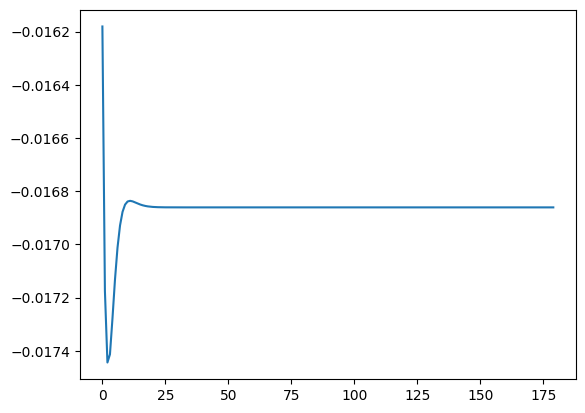

In [77]:
plt.plot(model(dataset[10]).detach().numpy().squeeze())
#plt.plot(dataset[10].detach().numpy().squeeze())